In [1]:
%matplotlib inline
from scipy import misc
from glob import glob

#test_images = list(map(misc.imread, glob('test_images/*.jpg')))
vehicle_images = [misc.imread(x, mode='RGB') for x in glob('vehicles/*/*.png')]
non_vehicle_images = [misc.imread(x, mode='RGB') for x in glob('non-vehicles/*/*.png')]
print("Loaded", len(vehicle_images), "vehicle images and", len(non_vehicle_images), "non-vehicle images.")

Loaded 8792 vehicle images and 8968 non-vehicle images.


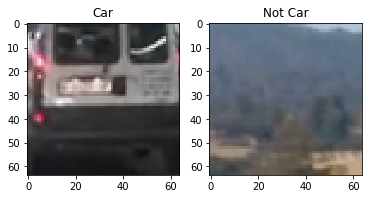

In [2]:
import matplotlib.pyplot as plt
fig = plt.figure()
fig.add_subplot(1,2,1).set_title("Car")
plt.imshow(vehicle_images[0])
fig.add_subplot(1,2,2).set_title("Not Car")
plt.imshow(non_vehicle_images[0])
fig.savefig("output_images/car_not_car.png")
plt.show()

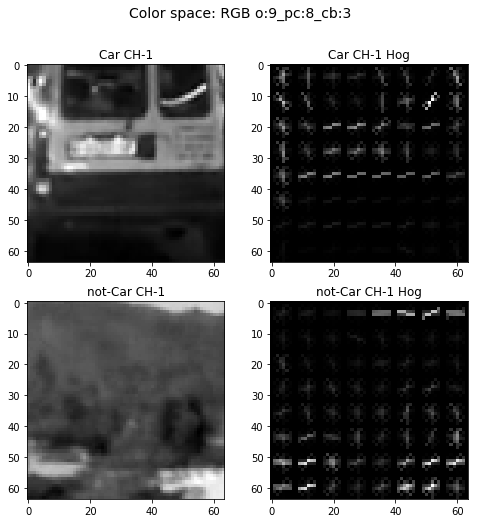

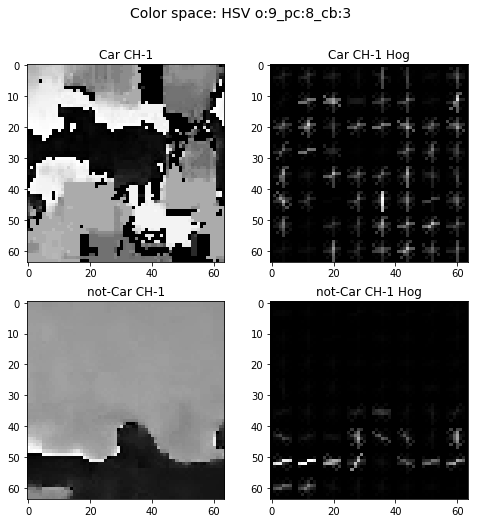

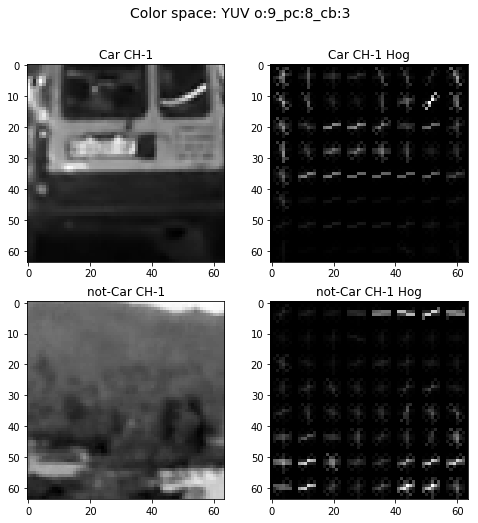

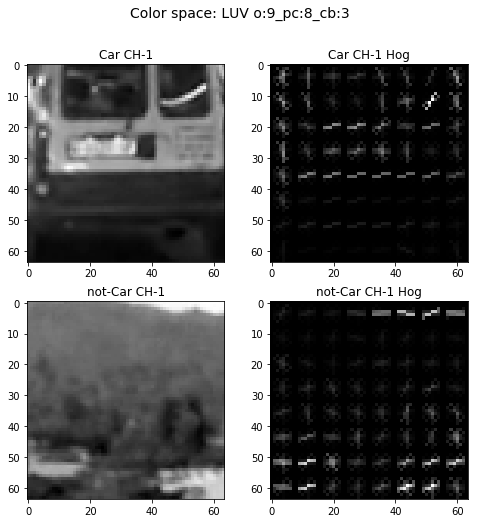

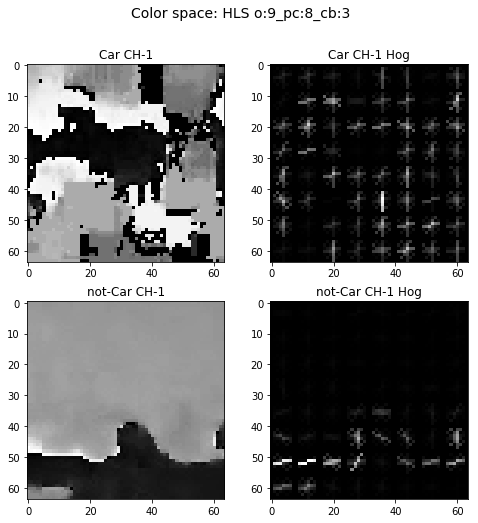

In [3]:
import cv2
import skimage
from skimage import feature, color
import numpy as np

def do_hog(image, orientations, pixels_per_cell, cells_per_block, visualise):
    ret = skimage.feature.hog(image, orientations=orientations, pixels_per_cell=(pixels_per_cell, pixels_per_cell),
                       cells_per_block=(cells_per_block, cells_per_block), block_norm='L2-Hys', visualise=visualise,
                       transform_sqrt=False, feature_vector=True)
    if visualise:
        plt.imshow(ret[1], cmap='gray')
    else:
        return ret

def convert_image(image, colorspace):
    conversion = {'HSV': cv2.COLOR_RGB2HSV, 'YUV': cv2.COLOR_RGB2YUV, 'LUV': cv2.COLOR_RGB2LUV, 'HLS': cv2.COLOR_RGB2HLS}
    if colorspace in conversion:
        return cv2.cvtColor(image, conversion[colorspace])
    else:
        return np.copy(image)
    
for colorspace in ['RGB', 'HSV', 'YUV', 'LUV', 'HLS']:
    vehicle_image = convert_image(vehicle_images[0], colorspace)
    non_vehicle_image = convert_image(non_vehicle_images[0], colorspace)

    for orientations in [9]:
        for pixels_per_cell in [8]:
            for cells_per_block in [3]:
                description = "o:" + str(orientations) + "_pc:" + str(pixels_per_cell) + "_cb:" + str(cells_per_block)
                fig = plt.figure(figsize = (8,8))
                fig.suptitle("Color space: " + colorspace + " " + description, fontsize=14)
                image = vehicle_image[:,:,0]
                fig.add_subplot(2,2,1).set_title("Car CH-1")
                plt.imshow(image, cmap='gray')
                fig.add_subplot(2,2,2).set_title("Car CH-1 Hog")
                do_hog(image, orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, visualise=True)

                image = non_vehicle_image[:,:,0]
                fig.add_subplot(2,2,3).set_title("not-Car CH-1")
                plt.imshow(image, cmap='gray')
                fig.add_subplot(2,2,4).set_title("not-Car CH-1 Hog")
                do_hog(image, orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, visualise=True)

                fig.savefig("output_images/HOG_" + colorspace + "_" + description + ".png")


In [4]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return np.array(features, dtype='int64')

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the feature vector
    return hist_features

def extract_features(image):
    image = convert_image(image, 'YUV')
    features = np.concatenate((bin_spatial(image), color_hist(image), do_hog(image[:,:,0], orientations=9, pixels_per_cell=8, cells_per_block=3, visualise=False)))
    


print("We have:", len(extract_features(vehicle_images[0])), "features per image")


We have: 6084 features per image


In [11]:
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler
X = [extract_features(x) for x in vehicle_images + non_vehicle_images]
X_scaler = StandardScaler().fit(X)
X = X_scaler.transform(X)

y = np.concatenate((np.ones(len(vehicle_images)),  np.zeros(len(non_vehicle_images)) ))

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=0)
print("We have", len(X_train), "training examples with", X_train[0].shape, "features each, and", len(X_test),"test examples" )

We have 14208 training examples with (6084,) features each, and 3552 test examples


In [12]:
from sklearn import svm

#parameters = {'kernel':['linear', 'rbf'], 'C':[1, 5, 10]}
parameters = {'kernel':['linear'], 'C':[1]}
svr = svm.SVC()
clf = model_selection.GridSearchCV(svr, parameters, verbose=1)
clf.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  7.2min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'kernel': ['linear'], 'C': [1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [13]:
clf.predict(X_test[0:3])

array([ 1.,  1.,  0.])

In [14]:
print("Best parameters are:\t\t", clf.best_params_)
print("Score on training data:\t\t", clf.best_score_)
print("Score on test data:\t\t", clf.score(X_test, y_test))

Best parameters are:		 {'kernel': 'linear', 'C': 1}
Score on training data:		 0.979166666667
Score on test data:		 0.980574324324


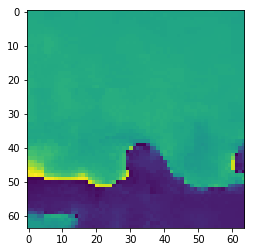

In [9]:
def draw_boxes(image, bboxes, color=(0, 0, 255), thick=6):
    image = np.copy(image)
    for bbox in bboxes:
        cv2.rectangle(image, bbox[0], bbox[1], color, thick)
    return image
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))
                       
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)
